# Notebook Imports

In [1]:
from os import walk
from os.path import join

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import nltk
from nltk.stem import PorterStemmer
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from bs4 import BeautifulSoup
from wordcloud import WordCloud
from PIL import Image


from sklearn.model_selection import train_test_split

%matplotlib inline

# Constants

In [2]:
EXAMPLE_FILE = "C:/Users/amar/ML Projects/SpamData/01_Processing/practice_email.txt"

SPAM_1_PATH = "C:/Users/amar/ML Projects/SpamData/01_Processing/spam_assassin_corpus/spam_1"
SPAM_2_PATH = "C:/Users/amar/ML Projects/SpamData/01_Processing/spam_assassin_corpus/spam_2"
EASY_NONSPAM_1_PATH = "C:/Users/amar/ML Projects/SpamData/01_Processing/spam_assassin_corpus/easy_ham_1"
EASY_NONSPAM_2_PATH = "C:/Users/amar/ML Projects/SpamData/01_Processing/spam_assassin_corpus/easy_ham_2"


SPAM_CAT = 1
HAM_CAT = 0
VOCAB_SIZE = 2500

DATA_JSON_FILE = 'C:/Users/amar/ML Projects/SpamData/01_Processing/email-text-data.json'
WORD_ID_FILE = 'C:/Users/amar/ML Projects/SpamData/01_Processing/word_by_id.csv'

TRAINING_DATA_FILE = 'C:/Users/amar/ML Projects/SpamData/02_Training/train-data.txt'
TEST_DATA_FILE = 'C:/Users/amar/ML Projects/SpamData/02_Training/test_data.txt'


WHALE_FILE = 'C:/Users/amar/ML Projects/SpamData/01_Processing/wordcloud_resources/whale-icon.png'
SKULL_FILE = 'C:/Users/amar/ML Projects/SpamData/01_Processing/wordcloud_resources/skull-icon.png'

THUMBS_UP = 'C:/Users/amar/ML Projects/SpamData/01_Processing/wordcloud_resources/thumbs_up.png'
THUMBS_DOWN = 'C:/Users/amar/ML Projects/SpamData/01_Processing/wordcloud_resources/thumbs_down.png'


# Gather Data ( Reading files)

In [3]:
#OPENING PRACTICE EMAIL FROM DATA
#EXTRACTING EMAIL BODY FROM WHOLE EMAIL TEXT
stream = open(EXAMPLE_FILE)

is_body = False 
lines = []

for line in stream:
    if is_body:
        lines.append(line)
        
    elif line == '\n':
        is_body = True

stream.close()

email_body = '\n'.join(lines)

print(email_body)



Dear Mr Still



Good tidings to you and all your staff for the festive season ahead (Christmas).

Now to the crux of the matter-in-hand: I am a fully qualified Santa Claus and am wondering whether you might consider me to run my own "Santa's Grotto" in your store.

But WAIT! You're probably thinking: "What makes him so special?"

Well, first of all, I have made several changes to the characterisation of Father Christmas. Rather than greeting the children with shouts of "Ho, ho, ho!" I prefer to whisper the phrase "Dependence is not unfathomable in this cruel world we live in". In addition, my gifts are ALL hand-made, ranging from felt hoops to vanilla-pod holders.

You will note also, from the enclosed sketch, that I have radically redesigned Santa's outfit and have renamed my character "Lord Buckles". Would you be interested in employing me? I promise NEVER to let you down.

I look forward to hearing from you.



Best wishes

Robin Cooper

[Excerpt from the book: The Timewaster Let

##  Email Body Extraction (Generator Functions)

In [4]:
def email_body_generator(path):
    
    for root, dirname, filenames in walk(path):  # walk() this function belongs to os library(from os import walk)
        for file_name in filenames:
            
            filepath = join(root, file_name)
            
            stream = open(filepath, encoding= 'latin_1')

            is_body = False 
            lines = []

            for line in stream:
                if is_body:
                    lines.append(line)

                elif line == '\n':
                    is_body = True

            stream.close()

            email_body = '\n'.join(lines)
            
            yield file_name, email_body

           
        

In [5]:
def df_from_directory(path, classification):
    rows = []
    row_name = []
    
    for file_name, email_body in email_body_generator(path):
        rows.append({'CATEGORY': classification, 'MESSAGE': email_body})
        row_name.append(file_name)
        
        
    return pd.DataFrame(rows, index= row_name)

### Spam emails

In [6]:
spam_emails = df_from_directory(SPAM_1_PATH, SPAM_CAT)
spam_emails = spam_emails.append(df_from_directory(SPAM_2_PATH, SPAM_CAT))
spam_emails.tail()

,CATEGORY,MESSAGE
01397.f75f0dd0dd923faefa3e9cc5ecb8c906,1,This is a multi-part message in MIME format.\n...
01398.8ca7045aae4184d56e8509dc5ad6d979,1,"Dear Subscriber,\n\n\n\nIf I could show you a ..."
01399.2319643317e2c5193d574e40a71809c2,1,****Mid-Summer Customer Appreciation SALE!****...
01400.b444b69845db2fa0a4693ca04e6ac5c5,1,ATTN:SIR/MADAN \n\n\n\n ...
cmds,1,


In [7]:
spam_emails.shape

(1898, 2)

### NonSpam emails

In [8]:
non_spam_emails = df_from_directory(EASY_NONSPAM_1_PATH, HAM_CAT)
non_spam_emails = non_spam_emails.append(df_from_directory(EASY_NONSPAM_1_PATH, HAM_CAT))
non_spam_emails.head()


,CATEGORY,MESSAGE
00001.7c53336b37003a9286aba55d2945844c,0,"Date: Wed, 21 Aug 2002 10:54:46 -05..."
00002.9c4069e25e1ef370c078db7ee85ff9ac,0,"Martin A posted:\n\nTassos Papadopoulos, the G..."
00003.860e3c3cee1b42ead714c5c874fe25f7,0,Man Threatens Explosion In Moscow \n\n\n\nThur...
00004.864220c5b6930b209cc287c361c99af1,0,Klez: The Virus That Won't Die\n\n \n\nAlready...
00005.bf27cdeaf0b8c4647ecd61b1d09da613,0,"> in adding cream to spaghetti carbonara, whi..."


In [9]:
non_spam_emails.shape

(5002, 2)

### 'data' : is the datafram which contain all spam and non spam emails

In [10]:
data = pd.concat([spam_emails, non_spam_emails])
print('shape of entire dataframe is ', data.shape)
data.head()

shape of entire dataframe is  (6900, 2)


,CATEGORY,MESSAGE
00001.7848dde101aa985090474a91ec93fcf0,1,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr..."
00002.d94f1b97e48ed3b553b3508d116e6a09,1,1) Fight The Risk of Cancer!\n\nhttp://www.adc...
00003.2ee33bc6eacdb11f38d052c44819ba6c,1,1) Fight The Risk of Cancer!\n\nhttp://www.adc...
00004.eac8de8d759b7e74154f142194282724,1,##############################################...
00005.57696a39d7d84318ce497886896bf90d,1,I thought you might like these:\n\n1) Slim Dow...


## DATA CLEANING : CHECKING FOR MISSSING VALUES

In [11]:
# CHECKING NULL VALUe
data['MESSAGE'].isnull().values.any()

False

In [12]:
# Check for empty email body
(data.MESSAGE.str.len() == 0).any() 

True

In [13]:
(data.MESSAGE.str.len() == 0).sum()

4

In [14]:
# locate empty email
data[data.MESSAGE.str.len() == 0].index

Index(['cmds', 'cmds', 'cmds', 'cmds'], dtype='object')

In [15]:
#above files are nothing but the files that have created when we Unzip the file whiCH is of no use
data.index[data.index=='cmds']

Index(['cmds', 'cmds', 'cmds', 'cmds'], dtype='object')

In [16]:
#droping the index of items name 'cmds'
data = data.drop(index=['cmds'])   

In [17]:
#to make sure there is no empty email body
(data.MESSAGE.str.len() == 0).sum()

0

In [18]:
data.tail()

,CATEGORY,MESSAGE
02496.aae0c81581895acfe65323f344340856,0,Man killed 'trying to surf' on Tube train \n\n...
02497.60497db0a06c2132ec2374b2898084d3,0,"Hi Gianni,\n\n\n\nA very good resource for thi..."
02498.09835f512f156da210efb99fcc523e21,0,Gianni Ponzi wrote:\n\n> I have a prob when tr...
02499.b4af165650f138b10f9941f6cc5bce3c,0,Neale Pickett <neale@woozle.org> writes:\n\n\n...
02500.05b3496ce7bca306bed0805425ec8621,0,"\n\nHi,\n\n\n\nI think you need to give us a l..."


In [19]:
data.iat[3, 1]

"##################################################\n\n#                                                #\n\n#                 Adult Club                     #\n\n#           Offers FREE Membership               #\n\n#                                                #\n\n##################################################\n\n\n\n>>>>>  INSTANT ACCESS TO ALL SITES NOW\n\n>>>>>  Your User Name And Password is.\n\n>>>>>  User Name: zzzz@spamassassin.taint.org\n\n>>>>>  Password: 760382\n\n\n\n5 of the Best Adult Sites on the Internet for FREE!\n\n---------------------------------------\n\nNEWS 08/18/02\n\nWith just over 2.9 Million Members that signed up for FREE, Last month there were 721,184 New\n\nMembers. Are you one of them yet???\n\n---------------------------------------\n\nOur Membership FAQ\n\n\n\nQ. Why are you offering free access to 5 adult membership sites for free?\n\nA. I have advertisers that pay me for ad space so you don't have to pay for membership.\n\n\n\nQ. Is it true m

### Add documents IDs to track Emails in Dataset

In [20]:
#creating document id and asign that as different column od DOC_ID in dataframe
documents_ids = range(0, len(data.index))
data['DOC_IDs'] = documents_ids

In [21]:
data.DOC_IDs

00001.7848dde101aa985090474a91ec93fcf0       0
00002.d94f1b97e48ed3b553b3508d116e6a09       1
00003.2ee33bc6eacdb11f38d052c44819ba6c       2
00004.eac8de8d759b7e74154f142194282724       3
00005.57696a39d7d84318ce497886896bf90d       4
                                          ... 
02496.aae0c81581895acfe65323f344340856    6891
02497.60497db0a06c2132ec2374b2898084d3    6892
02498.09835f512f156da210efb99fcc523e21    6893
02499.b4af165650f138b10f9941f6cc5bce3c    6894
02500.05b3496ce7bca306bed0805425ec8621    6895
Name: DOC_IDs, Length: 6896, dtype: int64

In [22]:
#creating column of name FILE_NAME,
data['FILE_NAME'] = data.index  
data.head()

,CATEGORY,MESSAGE,DOC_IDs,FILE_NAME
00001.7848dde101aa985090474a91ec93fcf0,1,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",0,00001.7848dde101aa985090474a91ec93fcf0
00002.d94f1b97e48ed3b553b3508d116e6a09,1,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1,00002.d94f1b97e48ed3b553b3508d116e6a09
00003.2ee33bc6eacdb11f38d052c44819ba6c,1,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,2,00003.2ee33bc6eacdb11f38d052c44819ba6c
00004.eac8de8d759b7e74154f142194282724,1,##############################################...,3,00004.eac8de8d759b7e74154f142194282724
00005.57696a39d7d84318ce497886896bf90d,1,I thought you might like these:\n\n1) Slim Dow...,4,00005.57696a39d7d84318ce497886896bf90d


In [23]:
#we setting the new index to our dataframe as DOC_IDs
data.set_index('DOC_IDs', inplace = True)
data

,CATEGORY,MESSAGE,FILE_NAME
DOC_IDs,,,
0,1,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",00001.7848dde101aa985090474a91ec93fcf0
1,1,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,00002.d94f1b97e48ed3b553b3508d116e6a09
2,1,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,00003.2ee33bc6eacdb11f38d052c44819ba6c
3,1,##############################################...,00004.eac8de8d759b7e74154f142194282724
4,1,I thought you might like these:\n\n1) Slim Dow...,00005.57696a39d7d84318ce497886896bf90d
...,...,...,...
6891,0,Man killed 'trying to surf' on Tube train \n\n...,02496.aae0c81581895acfe65323f344340856
6892,0,"Hi Gianni,\n\n\n\nA very good resource for thi...",02497.60497db0a06c2132ec2374b2898084d3
6893,0,Gianni Ponzi wrote:\n\n> I have a prob when tr...,02498.09835f512f156da210efb99fcc523e21


In [24]:
data.shape

(6896, 3)

# Data Visulization of no. of Spam Message (Pie Chart)

In [25]:
data.CATEGORY.value_counts()

0    5000
1    1896
Name: CATEGORY, dtype: int64

In [26]:
amount_of_spam = data.CATEGORY.value_counts()[1]
amount_of_ham = data.CATEGORY.value_counts()[0]

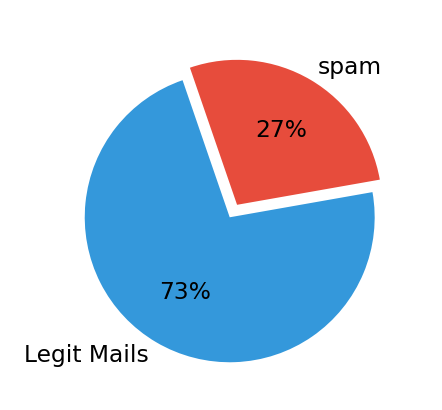

In [27]:
#visulizing in pichart
category_names = ['spam', 'Legit Mails']
sizes = [amount_of_spam, amount_of_ham]
custom_colors = ['#e74c3c', '#3498db']

plt.figure(figsize= (2, 2), dpi= 240)
plt.pie(sizes, labels=category_names, textprops= {'fontsize': 7}, startangle= 10, 
        autopct= '%1.0f%%', colors= custom_colors, explode= [0, 0.1])  
plt.show() 

## Text Pre-Processing

### Download the NLTK Resources (Tokenizer and Stopwords)

In [28]:
#downloading resource for tokenixe
nltk.download('punkt') 

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\amar\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [29]:
#downloading resource for remove stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\amar\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [30]:
#some addditional corpora f0r wordcloud trial
nltk.download('gutenberg')    
nltk.download('shakespeare')

[nltk_data] Downloading package gutenberg to
[nltk_data]     C:\Users\amar\AppData\Roaming\nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!
[nltk_data] Downloading package shakespeare to
[nltk_data]     C:\Users\amar\AppData\Roaming\nltk_data...
[nltk_data]   Package shakespeare is already up-to-date!


True

In [31]:
## Tokenizing
#Removing stopwords
#Word Stems and Stemming
#Removing Punctuation
#Removing HTML Tags from Emails

### FUNCTIONS FOR EMAIL PROCESSING

In [32]:
def clean_message(message, stemmer= PorterStemmer(),
                 stop_words= set(stopwords.words('english')) ):
    
  
    
    #convert into lower case and splits up the words
    words = word_tokenize(message.lower())

    filtered_words = []
    
    for word in words:
        #remove the stopwords and punctuation
        if word not in stop_words and word.isalpha():
            filtered_words.append(stemmer.stem(word))
            
    return filtered_words


In [33]:
clean_message(email_body)

['dear',
 'mr',
 'still',
 'good',
 'tide',
 'staff',
 'festiv',
 'season',
 'ahead',
 'christma',
 'crux',
 'fulli',
 'qualifi',
 'santa',
 'clau',
 'wonder',
 'whether',
 'might',
 'consid',
 'run',
 'santa',
 'grotto',
 'store',
 'wait',
 'probabl',
 'think',
 'make',
 'special',
 'well',
 'first',
 'made',
 'sever',
 'chang',
 'characteris',
 'father',
 'christma',
 'rather',
 'greet',
 'children',
 'shout',
 'ho',
 'ho',
 'ho',
 'prefer',
 'whisper',
 'phrase',
 'depend',
 'unfathom',
 'cruel',
 'world',
 'live',
 'addit',
 'gift',
 'rang',
 'felt',
 'hoop',
 'holder',
 'note',
 'also',
 'enclos',
 'sketch',
 'radic',
 'redesign',
 'santa',
 'outfit',
 'renam',
 'charact',
 'lord',
 'buckl',
 'would',
 'interest',
 'employ',
 'promis',
 'never',
 'let',
 'look',
 'forward',
 'hear',
 'best',
 'wish',
 'robin',
 'cooper',
 'excerpt',
 'book',
 'timewast',
 'letter',
 'robin',
 'cooper']

In [34]:
#modify to remove html tag
def clean_message_no_html(message, stemmer= PorterStemmer(),
                 stop_words= set(stopwords.words('english')) ):
    
    #remove html tag
    soup = BeautifulSoup(message)
    cleaned_text = soup.get_text()
    
    #convert into lower case and splits up the words
    words = word_tokenize(cleaned_text.lower())

    filtered_words = []
    
    for word in words:
        #remove the stopwords and punctuation
        if word not in stop_words and word.isalpha():
            filtered_words.append(stemmer.stem(word))
            
    return filtered_words

In [35]:
clean_message_no_html(data.at[2, 'MESSAGE'])

['fight',
 'risk',
 'cancer',
 'http',
 'slim',
 'guarante',
 'lose',
 'lb',
 'day',
 'http',
 'get',
 'child',
 'support',
 'deserv',
 'free',
 'legal',
 'advic',
 'http',
 'join',
 'web',
 'fastest',
 'grow',
 'singl',
 'commun',
 'http',
 'start',
 'privat',
 'photo',
 'album',
 'onlin',
 'http',
 'wonder',
 'day',
 'offer',
 'manag',
 'prizemama',
 'wish',
 'leav',
 'list',
 'pleas',
 'use',
 'link',
 'http',
 'zzzz']

In [36]:
%%time

#use apply() on all the messages in dataframe apply() is the property of pandas
nested_list = data.MESSAGE.apply(clean_message_no_html)

C:\Users\amar\anaconda3\lib\site-packages\bs4\__init__.py:431: MarkupResemblesLocatorWarning: "http://www.post-gazette.com/columnists/20020905brian5
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(


Wall time: 54.7 s


In [37]:
nested_list.head()

DOC_IDs
0    [save, life, insur, spend, life, quot, save, g...
1    [fight, risk, cancer, http, slim, guarante, lo...
2    [fight, risk, cancer, http, slim, guarante, lo...
3    [adult, club, offer, free, membership, instant...
4    [thought, might, like, slim, guarante, lose, l...
Name: MESSAGE, dtype: object

In [38]:
type(nested_list)

pandas.core.series.Series

### Using logic to slice DataFrame

In [39]:
#getting index of spam and nonSpam emails
doc_id_spam = data[data.CATEGORY == 1].index
doc_id_ham = data[data.CATEGORY == 0].index
doc_id_spam

Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            1886, 1887, 1888, 1889, 1890, 1891, 1892, 1893, 1894, 1895],
           dtype='int64', name='DOC_IDs', length=1896)

In [40]:
doc_id_ham

Int64Index([1896, 1897, 1898, 1899, 1900, 1901, 1902, 1903, 1904, 1905,
            ...
            6886, 6887, 6888, 6889, 6890, 6891, 6892, 6893, 6894, 6895],
           dtype='int64', name='DOC_IDs', length=5000)

In [41]:
#extrcting data from nested list providing index that we extract from datafram
nested_list_ham = nested_list.loc[doc_id_ham]   
nested_list_ham.shape

(5000,)

In [42]:
nested_list_ham.tail()

DOC_IDs
6891    [man, kill, surf, tube, train, ananova, wednes...
6892    [hi, gianni, good, resourc, http, http, walk, ...
6893    [gianni, ponzi, wrote, prob, tri, instal, linu...
6894    [neal, pickett, write, skip, montanaro, write,...
6895    [hi, think, need, give, us, littl, detail, inf...
Name: MESSAGE, dtype: object

In [43]:
 #extrcting data from nested list providing index that we extract from datafram
nested_list_spam = nested_list.loc[doc_id_spam] 
nested_list_spam.shape

(1896,)

In [44]:
nested_list_spam.tail()

DOC_IDs
1891    [want, boss, train, home, studi, thousand, peo...
1892    [messag, mime, format, prefer, doctor, order, ...
1893    [dear, subscrib, could, show, way, get, visito...
1894    [custom, appreci, sale, express, appreci, loya...
1895    [attn, strictli, confidenti, pleas, introduc, ...
Name: MESSAGE, dtype: object

In [45]:
#total no. of words in normal emails in dataset.
num_words_ham = [item for sublist in nested_list_ham for item in sublist]
normal_words = pd.Series(num_words_ham).value_counts()
normal_words.shape[0]


15733

In [46]:
normal_words[:10] #top 10 normal words

http      8624
use       4248
list      2772
get       2762
one       2676
mail      2476
like      2354
would     2284
messag    2180
time      2154
dtype: int64

In [47]:
#total no. of words in spam emails in dataset.
num_words_spam =[item for sublist in nested_list_spam for item in sublist]
spam_words = pd.Series(num_words_spam).value_counts()
spam_words.shape[0]
                

13225

In [48]:
spam_words[:10]  #top 10 spam words

http      3072
email     3061
free      2578
click     2043
receiv    1989
list      1952
get       1914
pleas     1840
busi      1791
order     1746
dtype: int64

## GENERATING VOCABOLARY AND DICTIONARY

In [49]:
stemmed_nested_list = data.MESSAGE.apply(clean_message_no_html)
flate_stemmed_list = [item for sublist in stemmed_nested_list for item in sublist]


In [50]:
len(flate_stemmed_list)

839321

In [51]:
unique_words = pd.Series(flate_stemmed_list).value_counts()
print('no. of unique words', unique_words.shape[0])
unique_words.head()

no. of unique words 22858


http     11696
use       5633
list      4724
get       4676
email     4437
dtype: int64

In [52]:
##subset of series called 'frequent_words' that only contain most common 2500 words out of total,

frequent_words = unique_words[0:VOCAB_SIZE]
print('most commom words: \n', frequent_words[:10])

most commom words: 
 http     11696
use       5633
list      4724
get       4676
email     4437
one       4207
mail      4187
free      3472
time      3451
like      3188
dtype: int64


### Create Vocabolory DataFrame with a  WORD_ID

In [53]:
word_ids = list(range(0, VOCAB_SIZE))
vocab = pd.DataFrame({'VOCAB_WORD' : frequent_words.index.values}, index= word_ids)
vocab.index.name = 'WORD_ID'   #giving name to to inddex column as word_ids
vocab.head()

,VOCAB_WORD
WORD_ID,
0,http
1,use
2,list
3,get
4,email


In [54]:
# save the vocobolary as csv file
vocab.to_csv(WORD_ID_FILE, index_label=vocab.index.name, header= vocab.VOCAB_WORD.name)

In [55]:
#Checking if a word is part of vocabolary

v_list = ['machine', 'learning', 'fun', 'learn', 'data', 'science', 'app', 'brewery', 'http']

for word in v_list:
    if word in vocab.VOCAB_WORD:
        print(True)
    else: 
        print(False)

False
False
False
False
False
False
False
False
False


### GENERATE FEATURES AND A SPARSE MATRIX
### creating a dataframe with one Word per Column

In [56]:
word_coulumn_df = pd.DataFrame.from_records(stemmed_nested_list.to_list())
word_coulumn_df.head()

,0,1,2,3,4,5,6,7,8,9,...,7344,7345,7346,7347,7348,7349,7350,7351,7352,7353
0,save,life,insur,spend,life,quot,save,g,famili,financi,...,None,None,None,None,None,None,None,None,None,None
1,fight,risk,cancer,http,slim,guarante,lose,lb,day,http,...,None,None,None,None,None,None,None,None,None,None
2,fight,risk,cancer,http,slim,guarante,lose,lb,day,http,...,None,None,None,None,None,None,None,None,None,None
3,adult,club,offer,free,membership,instant,access,site,user,name,...,None,None,None,None,None,None,None,None,None,None
4,thought,might,like,slim,guarante,lose,lb,day,http,fight,...,None,None,None,None,None,None,None,None,None,None


In [57]:
word_coulumn_df.shape

(6896, 7354)

### Splitting Data into a Training and Testing Dataset

In [58]:
X_train, X_test, y_train, y_test = train_test_split(word_coulumn_df, data.CATEGORY, test_size= 0.3, random_state=42)


In [59]:
print('num of training sample', X_train.shape[0])
print('fraction of training set', X_train.shape[0] / word_coulumn_df.shape[0])

num of training sample 4827
fraction of training set 0.6999709976798144


In [60]:
X_train.index.name = X_test.index.name = 'DOC_ID'
X_train.head()

,0,1,2,3,4,5,6,7,8,9,...,7344,7345,7346,7347,7348,7349,7350,7351,7352,7353
DOC_ID,,,,,,,,,,,,,,,,,,,,,
1294,stop,pay,adult,site,show,hot,get,free,password,free,...,None,None,None,None,None,None,None,None,None,None
6472,url,http,date,think,get,new,mac,good,reason,though,...,None,None,None,None,None,None,None,None,None,None
5792,inlin,mon,sep,justin,mason,wrote,razor,support,fulli,chang,...,None,None,None,None,None,None,None,None,None,None
6438,url,http,date,media,took,one,column,newspap,rod,liddl,...,None,None,None,None,None,None,None,None,None,None
4922,begin,forward,text,prioriti,normal,date,mon,sep,law,polici,...,None,None,None,None,None,None,None,None,None,None


In [61]:
y_train.head()

DOC_IDs
1294    1
6472    0
5792    0
6438    0
4922    0
Name: CATEGORY, dtype: int64

In [62]:
### Create a Sparse Matrix for the Training Data

word_index = pd.Index(vocab.VOCAB_WORD)
type(word_index[3])

str

In [63]:
def make_sparse_matrix(df, indexed_words, labels):
    """
    
    return sparse marix as dataframe
    
    df: A DataFrame with the words in the columns with document id as an index (X_train or X_test)
    indexed_words: index of words ordered by word id
    labels: category as series (y_train, y_test)
    
    """
    num_rows = df.shape[0]
    num_cols = df.shape[1]
    word_set = set(indexed_words)
    dict_list = []
    
    for i in range((num_rows)):
        for j in range(num_cols):
            
            word = df.iat[i, j]
            if word in word_set:
                doc_id = df.index[i]
                word_id = indexed_words.get_loc(word)
                category = labels.at[doc_id]
                
                item = {'Label': category, 'DOC_ID': doc_id, 'OCCURENCE': 1, 'WORD_ID': word_id}
                
                dict_list.append(item)
                
    return pd.DataFrame(dict_list)
                
    
    

In [64]:
%%time

sparse_train_df = make_sparse_matrix(X_train, word_index, y_train)


Wall time: 15min 21s


In [65]:
sparse_train_df[:5]

,Label,DOC_ID,OCCURENCE,WORD_ID
0,1,1294,1,334
1,1,1294,1,231
2,1,1294,1,1096
3,1,1294,1,54
4,1,1294,1,196


In [66]:
sparse_train_df[-5:]

,Label,DOC_ID,OCCURENCE,WORD_ID
479121,1,860,1,52
479122,1,860,1,1450
479123,1,860,1,30
479124,1,860,1,22
479125,1,860,1,126


In [67]:
# Combine Occurences with pandas groupby() method
train_grouped = sparse_train_df.groupby(['DOC_ID', 'WORD_ID', 'Label']).sum()
train_grouped.head()



OCCURENCE
DOC_ID WORD_ID Label           
0      2       1              1
       3       1              1
       4       1              1
       7       1              3
       14      1              1

In [68]:
vocab.at[0, 'VOCAB_WORD']

'http'

In [69]:
data.MESSAGE[0]

'<!DOCTYPE HTML PUBLIC "-//W3C//DTD HTML 4.0 Transitional//EN">\n\n<HTML><HEAD>\n\n<META content=3D"text/html; charset=3Dwindows-1252" http-equiv=3DContent-T=\n\nype>\n\n<META content=3D"MSHTML 5.00.2314.1000" name=3DGENERATOR></HEAD>\n\n<BODY><!-- Inserted by Calypso -->\n\n<TABLE border=3D0 cellPadding=3D0 cellSpacing=3D2 id=3D_CalyPrintHeader_ r=\n\nules=3Dnone \n\nstyle=3D"COLOR: black; DISPLAY: none" width=3D"100%">\n\n  <TBODY>\n\n  <TR>\n\n    <TD colSpan=3D3>\n\n      <HR color=3Dblack noShade SIZE=3D1>\n\n    </TD></TR></TD></TR>\n\n  <TR>\n\n    <TD colSpan=3D3>\n\n      <HR color=3Dblack noShade SIZE=3D1>\n\n    </TD></TR></TBODY></TABLE><!-- End Calypso --><!-- Inserted by Calypso=\n\n --><FONT \n\ncolor=3D#000000 face=3DVERDANA,ARIAL,HELVETICA size=3D-2><BR></FONT></TD><=\n\n/TR></TABLE><!-- End Calypso --><FONT color=3D#ff0000 \n\nface=3D"Copperplate Gothic Bold" size=3D5 PTSIZE=3D"10">\n\n<CENTER>Save up to 70% on Life Insurance.</CENTER></FONT><FONT color=3D#ff=\n\n0000

In [70]:
train_grouped = train_grouped.reset_index()
train_grouped.head()

,DOC_ID,WORD_ID,Label,OCCURENCE
0,0,2,1,1
1,0,3,1,1
2,0,4,1,1
3,0,7,1,3
4,0,14,1,1


In [71]:
train_grouped.tail()

,DOC_ID,WORD_ID,Label,OCCURENCE
292815,6895,2182,0,1
292816,6895,2202,0,2
292817,6895,2236,0,1
292818,6895,2280,0,1
292819,6895,2327,0,1


In [72]:
vocab.at[1698, 'VOCAB_WORD'] #TO know thw word a positin world_id of 1698


'highest'

In [73]:
data.MESSAGE[6895]

"\n\nHi,\n\n\n\nI think you need to give us a little more detailed information.\n\n\n\nOn Wed, 04 Dec 2002, Gianni Ponzi wrote:\n\n\n\n> I have a prob when trying to install Linux (tried RedHat, Suse) on my\n\n> laptop. \n\n\n\nYou get _exactly_ the same problem with Suse and RedHat, is that right?\n\nWhat versions of these have you used?\n\n\n\n> I can start the install but after about 2min, the whole pc just\n\n> dies.\n\n\n\nAs in freezes, reboots?  Do you get any errors?\n\n\n\n> I know it's not a Linux prob and here is what I have encountered:\n\n> \n\n> I had the same problem when installing Win on it and eventually sorted it\n\n> out by disabling the infrared port. \n\n\n\nDid you disable it in the BIOS or in windows?\n\n\n\n> I'm guessing this might be same prob although I'm not sure. I am very new\n\n> to Linux so it's not that easy for me to work it out. I did manage to\n\n> follow the setup procedure at one stage (using images on disks) and it\n\n> cuts out either as it's tr

In [74]:
train_grouped.shape

(292820, 4)

In [75]:
## Save Training Data as .txt File
np.savetxt(TRAINING_DATA_FILE, train_grouped, fmt= '%d')

In [76]:
train_grouped.columns

Index(['DOC_ID', 'WORD_ID', 'Label', 'OCCURENCE'], dtype='object')

In [77]:
#create a sparse matrix for the test data. Grouped the occurence of the same email. then save the data as .txt file

X_test.head()

,0,1,2,3,4,5,6,7,8,9,...,7344,7345,7346,7347,7348,7349,7350,7351,7352,7353
DOC_ID,,,,,,,,,,,,,,,,,,,,,
852,freightmart,mail,campaign,ship,anyth,anywher,anytim,auction,style,need,...,None,None,None,None,None,None,None,None,None,None
3698,use,perl,daili,newslett,issu,week,septemb,great,perl,monger,...,None,None,None,None,None,None,None,None,None,None
3023,oop,turn,care,instal,exmh,librari,variabl,point,old,instal,...,None,None,None,None,None,None,None,None,None,None
2840,robert,elz,date,sat,aug,date,thu,aug,chri,garrigu,...,None,None,None,None,None,None,None,None,None,None
1694,messag,mime,format,life,polici,critic,ill,life,insur,termin,...,None,None,None,None,None,None,None,None,None,None


In [78]:
y_test.head()

DOC_IDs
852     1
3698    0
3023    0
2840    0
1694    1
Name: CATEGORY, dtype: int64

In [79]:
%%time 

sparse_test_df = make_sparse_matrix(X_test, word_index, y_test)


Wall time: 6min 23s


In [80]:
sparse_test_df.shape

(219808, 4)

In [81]:
test_grouped = sparse_test_df.groupby(['DOC_ID', 'WORD_ID', 'Label']).sum().reset_index()
test_grouped.head()

,DOC_ID,WORD_ID,Label,OCCURENCE
0,8,2,1,1
1,8,3,1,2
2,8,4,1,4
3,8,5,1,2
4,8,6,1,1


In [82]:
test_grouped.shape

(128813, 4)

In [83]:
np.savetxt(TEST_DATA_FILE, test_grouped, fmt= '%d')

### Pre-Processing Sublists 

In [84]:
train_doc_ids = set(train_grouped.DOC_ID)
test_doc_ids = set(test_grouped.DOC_ID)

In [85]:
len(train_doc_ids)

4782

In [86]:
len(X_train)

4827

In [87]:
len(test_doc_ids)

2052

In [88]:
len(X_test)             # there are some emails aere miisng from test_doc_ids to xtest same for train

2069

In [89]:
set(X_test.index.values) - test_doc_ids

{73,
 91,
 179,
 240,
 339,
 439,
 471,
 734,
 742,
 765,
 940,
 965,
 1095,
 1170,
 1360,
 1544,
 1670}

In [90]:
data.MESSAGE[73]

'------=_NextPart_000_00C2_37C70C2D.A8844B81\n\nContent-Type: text/html; charset="iso-8859-1"\n\nContent-Transfer-Encoding: base64\n\n\n\n\n\nPCFET0NUWVBFIEhUTUwgUFVCTElDICItLy9XM0MvL0RURCBIVE1MIDQuMDEg\n\nVHJhbnNpdGlvbmFsLy9FTiI+DQo8aHRtbD4NCjxoZWFkPg0KPHRpdGxlPkFk\n\ndWx0IENsYXNzaWZpZWQgMmsyPC90aXRsZT4NCjxtZXRhIGh0dHAtZXF1aXY9\n\nIkNvbnRlbnQtVHlwZSIgY29udGVudD0idGV4dC9odG1sOyBjaGFyc2V0PWlz\n\nby04ODU5LTEiPg0KPC9oZWFkPg0KDQo8Ym9keSBiZ2NvbG9yPSIjRkZGRkZG\n\nIiBsaW5rPSIjQ0M5OTk5IiBsZWZ0bWFyZ2luPSIwIiB0b3BtYXJnaW49IjAi\n\nIG1hcmdpbndpZHRoPSIwIiBtYXJnaW5oZWlnaHQ9IjAiPg0KDQo8Y2VudGVy\n\nPg0KICA8YnI+DQogIDx0YWJsZSB3aWR0aD0iNjAwIiBib3JkZXI9IjAiIGNl\n\nbGxzcGFjaW5nPSIwIiBjZWxscGFkZGluZz0iMSI+DQogICAgPHRyPg0KICAg\n\nICAgPHRkIGJnY29sb3I9IiM5OTAwMDAiPjx0YWJsZSB3aWR0aD0iNjAwIiBi\n\nb3JkZXI9IjAiIGNlbGxzcGFjaW5nPSIwIiBjZWxscGFkZGluZz0iMCI+DQog\n\nICAgICAgICAgPHRyPg0KICAgICAgICAgICAgPHRkIGJnY29sb3I9IiNGRkZG\n\nRkYiPg0KICAgICAgICAgIA0KICAgICAgICAgIDxkaXYgYWxpZ249InJpZ2h0\n\nIj48aW1nIHNyYz0iaHR0cDovL3

In [91]:
clean_message_no_html(data.at[73, 'MESSAGE']) 

[]

In [92]:
clean_message(data.at[73, 'MESSAGE'])

[]